<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_with_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error


     |████████████████████████████████| 1.1 MB 4.1 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Import data

In [27]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date","ConfirmedCases", "ConfirmedDeaths"]]

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths (before infect found)
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# # replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)

# reset index
data = data.reset_index(drop = True)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# remove the last rows with incomplete info
data = data.loc[~(data[["ConfirmedCases"]]==0).all(axis=1)]

# reset index
data = data.reset_index(drop = True)

data2 = data

# drop confirmed cases and confirmed deaths
data = data.drop(['ConfirmedCases', 'ConfirmedDeaths', 'Date'], axis=1)

# data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



## Data Preprocessing: Multivariate

In [12]:
lag = 14
prediction = 1
index = 30

# confirmed cases
nrow_total = data.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data[i:lag+i], axis=0) for i in range(nrow_total)] 
X_i_p = np.concatenate(input_list, axis=0)

y_i_p = np.array([data.Cases_daily[lag:data.shape[0]]])
y_i_p = y_i_p.T # transpose the matrix

# split into training and test sets
X_i_p_tr = X_i_p[0:index+1, :, :]
X_i_p_ts = X_i_p[index+1:data.shape[0], :, :]

y_i_p_tr = y_i_p[0:index+1]
y_i_p_ts = y_i_p[index+1:data.shape[0]]

# confirmed deaths
nrow_total = data.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data[i:lag+i], axis=0) for i in range(nrow_total)] 
X_d_p = np.concatenate(input_list, axis=0)

y_d_p = np.array([data.Deaths_daily[lag:data.shape[0]]])
y_d_p = y_d_p.T # transpose the matrix


# split into training and test sets
X_d_p_tr = X_d_p[0:index+1, :, :]
X_d_p_ts = X_d_p[index+1:data.shape[0], :, :]

y_d_p_tr = y_d_p[0:index+1]
y_d_p_ts = y_d_p[index+1:data.shape[0]]


## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [13]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [14]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

cnn_i_multi = pd.DataFrame(cnn_i_multi).T
cnn_i_multi.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 6.480
filter = 4, kernel size = 3, pooling size = 2: 6.135
filter = 8, kernel size = 3, pooling size = 2: 7.039
filter = 16, kernel size = 3, pooling size = 2: 5.090
filter = 32, kernel size = 3, pooling size = 2: 5.637
filter = 64, kernel size = 3, pooling size = 2: 5.099
filter = 128, kernel size = 3, pooling size = 2: 5.327
filter = 256, kernel size = 3, pooling size = 2: 5.430
filter = 512, kernel size = 3, pooling size = 2: 6.248
filter = 1024, kernel size = 3, pooling size = 2: 6.830
filter = 2, kernel size = 5, pooling size = 2: 6.647
filter = 4, kernel size = 5, pooling size = 2: 6.249
filter = 8, kernel size = 5, pooling size = 2: 6.684
filter = 16, kernel size = 5, pooling size = 2: 6.073
filter = 32, kernel size = 5, pooling size = 2: 5.628
filter = 64, kernel size = 5, pooling size = 2: 5.317
filter = 128, kernel size = 5, pooling size = 2: 5.418
filter = 256, kernel size = 5, pooling size = 2: 5.377
filter = 512, kernel size =

In [15]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

cnn_d_multi = pd.DataFrame(cnn_d_multi).T
cnn_d_multi.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 148.430
filter = 4, kernel size = 3, pooling size = 2: 103.859
filter = 8, kernel size = 3, pooling size = 2: 82.415
filter = 16, kernel size = 3, pooling size = 2: 82.483
filter = 32, kernel size = 3, pooling size = 2: 25.726
filter = 64, kernel size = 3, pooling size = 2: 38.086
filter = 128, kernel size = 3, pooling size = 2: 22.954
filter = 256, kernel size = 3, pooling size = 2: 125.163
filter = 512, kernel size = 3, pooling size = 2: 14.512
filter = 1024, kernel size = 3, pooling size = 2: 15.984
filter = 2, kernel size = 5, pooling size = 2: 172.771
filter = 4, kernel size = 5, pooling size = 2: 96.059
filter = 8, kernel size = 5, pooling size = 2: 82.170
filter = 16, kernel size = 5, pooling size = 2: 60.991
filter = 32, kernel size = 5, pooling size = 2: 81.041
filter = 64, kernel size = 5, pooling size = 2: 27.628
filter = 128, kernel size = 5, pooling size = 2: 24.158
filter = 256, kernel size = 5, pooling size = 2: 14.050
filte

### LSTM

In [16]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_p_tr, y_i_p_tr, i)
  lstm_i_multi.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_p_tr, y_d_p_tr, i)
  lstm_d_multi.append(score)

### GRU

In [17]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Multivariate GRU confirmed cases

gru_i_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_p_tr, y_i_p_tr, i)
  gru_i_multi.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_p_tr, y_d_p_tr, i)
  gru_d_multi.append(score)

### RNNs

In [18]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy



# Multivariate RNNs confirmed cases

rnn_i_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_p_tr, y_i_p_tr, i)
  rnn_i_multi.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_p_tr, y_d_p_tr, i)
  rnn_d_multi.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [19]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi[0],3), 
                                     round(gru_i_multi[0],3),
                                     round(rnn_i_multi[0],3), 
                                     round(cnn_i_multi.iloc[0,0],3),
                                     round(cnn_i_multi.iloc[0,1],3),
                                     round(cnn_i_multi.iloc[0,2],3),
                                     round(cnn_i_multi.iloc[0,3],3),
                                     round(cnn_i_multi.iloc[0,4],3),
                                     round(cnn_i_multi.iloc[0,5],3)],
                                     [round(lstm_i_multi[1],3), 
                                     round(gru_i_multi[1],3),
                                     round(rnn_i_multi[1],3), 
                                     round(cnn_i_multi.iloc[1,0],3),
                                     round(cnn_i_multi.iloc[1,1],3),
                                     round(cnn_i_multi.iloc[1,2],3),
                                     round(cnn_i_multi.iloc[1,3],3),
                                     round(cnn_i_multi.iloc[1,4],3),
                                     round(cnn_i_multi.iloc[1,5],3)],
                                     [round(lstm_i_multi[2],3), 
                                     round(gru_i_multi[2],3),
                                     round(rnn_i_multi[2],3), 
                                     round(cnn_i_multi.iloc[2,0],3),
                                     round(cnn_i_multi.iloc[2,1],3),
                                     round(cnn_i_multi.iloc[2,2],3),
                                     round(cnn_i_multi.iloc[2,3],3),
                                     round(cnn_i_multi.iloc[2,4],3),
                                     round(cnn_i_multi.iloc[2,5],3)],
                                     [round(lstm_i_multi[3],3), 
                                     round(gru_i_multi[3],3),
                                     round(rnn_i_multi[3],3), 
                                     round(cnn_i_multi.iloc[3,0],3),
                                     round(cnn_i_multi.iloc[3,1],3),
                                     round(cnn_i_multi.iloc[3,2],3),
                                     round(cnn_i_multi.iloc[3,3],3),
                                     round(cnn_i_multi.iloc[3,4],3),
                                     round(cnn_i_multi.iloc[3,5],3)],
                                     [round(lstm_i_multi[4],3), 
                                     round(gru_i_multi[4],3),
                                     round(rnn_i_multi[4],3), 
                                     round(cnn_i_multi.iloc[4,0],3),
                                     round(cnn_i_multi.iloc[4,1],3),
                                     round(cnn_i_multi.iloc[4,2],3),
                                     round(cnn_i_multi.iloc[4,3],3),
                                     round(cnn_i_multi.iloc[4,4],3),
                                     round(cnn_i_multi.iloc[4,5],3)],
                                     [round(lstm_i_multi[5],3), 
                                     round(gru_i_multi[5],3),
                                     round(rnn_i_multi[5],3), 
                                     round(cnn_i_multi.iloc[5,0],3),
                                     round(cnn_i_multi.iloc[5,1],3),
                                     round(cnn_i_multi.iloc[5,2],3),
                                     round(cnn_i_multi.iloc[5,3],3),
                                     round(cnn_i_multi.iloc[5,4],3),
                                     round(cnn_i_multi.iloc[5,5],3)],
                                     [round(lstm_i_multi[6],3), 
                                     round(gru_i_multi[6],3),
                                     round(rnn_i_multi[6],3), 
                                     round(cnn_i_multi.iloc[6,0],3),
                                     round(cnn_i_multi.iloc[6,1],3),
                                     round(cnn_i_multi.iloc[6,2],3),
                                     round(cnn_i_multi.iloc[6,3],3),
                                     round(cnn_i_multi.iloc[6,4],3),
                                     round(cnn_i_multi.iloc[6,5],3)],
                                     [round(lstm_i_multi[7],3), 
                                     round(gru_i_multi[7],3),
                                     round(rnn_i_multi[7],3), 
                                     round(cnn_i_multi.iloc[7,0],3),
                                     round(cnn_i_multi.iloc[7,1],3),
                                     round(cnn_i_multi.iloc[7,2],3),
                                     round(cnn_i_multi.iloc[7,3],3),
                                     round(cnn_i_multi.iloc[7,4],3),
                                     round(cnn_i_multi.iloc[7,5],3)],
                                     [round(lstm_i_multi[8],3), 
                                     round(gru_i_multi[8],3),
                                     round(rnn_i_multi[8],3), 
                                     round(cnn_i_multi.iloc[8,0],3),
                                     round(cnn_i_multi.iloc[8,1],3),
                                     round(cnn_i_multi.iloc[8,2],3),
                                     round(cnn_i_multi.iloc[8,3],3),
                                     round(cnn_i_multi.iloc[8,4],3),
                                     round(cnn_i_multi.iloc[8,5],3)],
                                     [round(lstm_i_multi[9],3), 
                                     round(gru_i_multi[9],3),
                                     round(rnn_i_multi[9],3), 
                                     round(cnn_i_multi.iloc[9,0],3),
                                     round(cnn_i_multi.iloc[9,1],3),
                                     round(cnn_i_multi.iloc[9,2],3),
                                     round(cnn_i_multi.iloc[9,3],3),
                                     round(cnn_i_multi.iloc[9,4],3),
                                     round(cnn_i_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [20]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi[0],3), 
                                     round(gru_d_multi[0],3),
                                     round(rnn_d_multi[0],3), 
                                     round(cnn_d_multi.iloc[0,0],3),
                                     round(cnn_d_multi.iloc[0,1],3),
                                     round(cnn_d_multi.iloc[0,2],3),
                                     round(cnn_d_multi.iloc[0,3],3),
                                     round(cnn_d_multi.iloc[0,4],3),
                                     round(cnn_d_multi.iloc[0,5],3)],
                                     [round(lstm_d_multi[1],3), 
                                     round(gru_d_multi[1],3),
                                     round(rnn_d_multi[1],3), 
                                     round(cnn_d_multi.iloc[1,0],3),
                                     round(cnn_d_multi.iloc[1,1],3),
                                     round(cnn_d_multi.iloc[1,2],3),
                                     round(cnn_d_multi.iloc[1,3],3),
                                     round(cnn_d_multi.iloc[1,4],3),
                                     round(cnn_d_multi.iloc[1,5],3)],
                                     [round(lstm_d_multi[2],3), 
                                     round(gru_d_multi[2],3),
                                     round(rnn_d_multi[2],3), 
                                     round(cnn_d_multi.iloc[2,0],3),
                                     round(cnn_d_multi.iloc[2,1],3),
                                     round(cnn_d_multi.iloc[2,2],3),
                                     round(cnn_d_multi.iloc[2,3],3),
                                     round(cnn_d_multi.iloc[2,4],3),
                                     round(cnn_d_multi.iloc[2,5],3)],
                                     [round(lstm_d_multi[3],3), 
                                     round(gru_d_multi[3],3),
                                     round(rnn_d_multi[3],3), 
                                     round(cnn_d_multi.iloc[3,0],3),
                                     round(cnn_d_multi.iloc[3,1],3),
                                     round(cnn_d_multi.iloc[3,2],3),
                                     round(cnn_d_multi.iloc[3,3],3),
                                     round(cnn_d_multi.iloc[3,4],3),
                                     round(cnn_d_multi.iloc[3,5],3)],
                                     [round(lstm_d_multi[4],3), 
                                     round(gru_d_multi[4],3),
                                     round(rnn_d_multi[4],3), 
                                     round(cnn_d_multi.iloc[4,0],3),
                                     round(cnn_d_multi.iloc[4,1],3),
                                     round(cnn_d_multi.iloc[4,2],3),
                                     round(cnn_d_multi.iloc[4,3],3),
                                     round(cnn_d_multi.iloc[4,4],3),
                                     round(cnn_d_multi.iloc[4,5],3)],
                                     [round(lstm_d_multi[5],3), 
                                     round(gru_d_multi[5],3),
                                     round(rnn_d_multi[5],3), 
                                     round(cnn_d_multi.iloc[5,0],3),
                                     round(cnn_d_multi.iloc[5,1],3),
                                     round(cnn_d_multi.iloc[5,2],3),
                                     round(cnn_d_multi.iloc[5,3],3),
                                     round(cnn_d_multi.iloc[5,4],3),
                                     round(cnn_d_multi.iloc[5,5],3)],
                                     [round(lstm_d_multi[6],3), 
                                     round(gru_d_multi[6],3),
                                     round(rnn_d_multi[6],3), 
                                     round(cnn_d_multi.iloc[6,0],3),
                                     round(cnn_d_multi.iloc[6,1],3),
                                     round(cnn_d_multi.iloc[6,2],3),
                                     round(cnn_d_multi.iloc[6,3],3),
                                     round(cnn_d_multi.iloc[6,4],3),
                                     round(cnn_d_multi.iloc[6,5],3)],
                                     [round(lstm_d_multi[7],3), 
                                     round(gru_d_multi[7],3),
                                     round(rnn_d_multi[7],3), 
                                     round(cnn_d_multi.iloc[7,0],3),
                                     round(cnn_d_multi.iloc[7,1],3),
                                     round(cnn_d_multi.iloc[7,2],3),
                                     round(cnn_d_multi.iloc[7,3],3),
                                     round(cnn_d_multi.iloc[7,4],3),
                                     round(cnn_d_multi.iloc[7,5],3)],
                                     [round(lstm_d_multi[8],3), 
                                     round(gru_d_multi[8],3),
                                     round(rnn_d_multi[8],3), 
                                     round(cnn_d_multi.iloc[8,0],3),
                                     round(cnn_d_multi.iloc[8,1],3),
                                     round(cnn_d_multi.iloc[8,2],3),
                                     round(cnn_d_multi.iloc[8,3],3),
                                     round(cnn_d_multi.iloc[8,4],3),
                                     round(cnn_d_multi.iloc[8,5],3)],
                                     [round(lstm_d_multi[9],3), 
                                     round(gru_d_multi[9],3),
                                     round(rnn_d_multi[9],3), 
                                     round(cnn_d_multi.iloc[9,0],3),
                                     round(cnn_d_multi.iloc[9,1],3),
                                     round(cnn_d_multi.iloc[9,2],3),
                                     round(cnn_d_multi.iloc[9,3],3),
                                     round(cnn_d_multi.iloc[9,4],3),
                                     round(cnn_d_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [21]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_i = Sequential()
# model_multi_i.add(Conv1D(filters = 4, kernel_size = 5, activation='relu', input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
# model_multi_i.add(MaxPooling1D(pool_size = 2))
# model_multi_i.add(Flatten())
# model_multi_i.add(Dense(64, activation = "relu"))
# model_multi_i.add(Dense(1, activation = "linear"))
# model_multi_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_i = Sequential()
model_multi_i.add(SimpleRNN(32, activation='relu', input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
# model_multi_i.add(Dense(32, activation = "relu"))
model_multi_i.add(Dense(1, activation = "linear"))
model_multi_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_i.fit(X_i_p_tr, y_i_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_i1 = model_multi_i.evaluate(X_i_p_tr, y_i_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_i1[1])

scores_multi_i = model_multi_i.evaluate(X_i_p_ts, y_i_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_i[1])

MAPE: training =  4.844964504241943
MAPE: test =  201933848576.0


In [22]:
# make a prediction
# training set
y_multi_i_tr = pd.DataFrame(model_multi_i.predict(X_i_p_tr))

# test set
y_multi_i_ts = pd.DataFrame(model_multi_i.predict(X_i_p_ts))

# combine training and test predictions
y_multi_i_total = pd.concat([y_multi_i_tr, y_multi_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [23]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_d = Sequential()
# model_multi_d.add(GRU(8, activation = 'relu', input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2])))
# model_multi_d.add(Dense(4, activation = "relu"))
# model_multi_d.add(Dense(1, activation = "linear"))
# model_multi_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_d = Sequential()
model_multi_d.add(Conv1D(1024, kernel_size = 7, activation = 'relu', input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2])))
model_multi_d.add(MaxPooling1D(2))
model_multi_d.add(Flatten())
model_multi_d.add(Dense(1, activation = "linear"))
model_multi_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_d.fit(X_d_p_tr, y_d_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_d1 = model_multi_d.evaluate(X_d_p_tr, y_d_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_d1[1])

scores_multi_d = model_multi_d.evaluate(X_d_p_ts, y_d_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_d[1])

MAPE: training =  11.258814811706543
MAPE: test =  1567862144.0


In [24]:
# make a prediction
# training set
y_multi_d_tr = pd.DataFrame(model_multi_d.predict(X_d_p_tr))

# test set
y_multi_d_ts = pd.DataFrame(model_multi_d.predict(X_d_p_ts))

# combine training and test predictions
y_multi_d_total = pd.concat([y_multi_d_tr, y_multi_d_ts], ignore_index=True)


In [31]:
multi_in = "RNNs"
multi_de = "CNN"
tick_spacing = 5
date_test = data2['Date'][0+index+lag-1]

### Plots

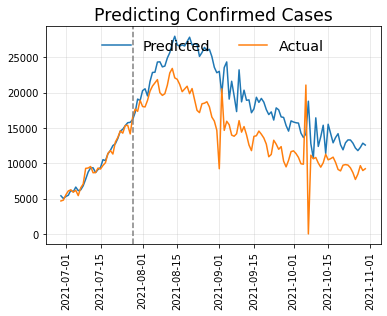

In [32]:
infect = pd.concat([y_multi_i_total,
                   data2.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data2.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Predicting Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)





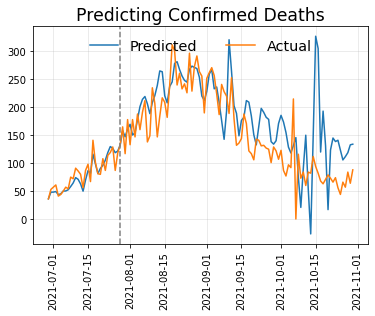

In [34]:

death = pd.concat([y_multi_d_total,
                   data2.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data2.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Predicting Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

### Result Table

In [35]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_i1[1],3), round(scores_multi_d1[1],3)],
                                    [round(scores_multi_i[1],3), round(scores_multi_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()